# `GloMarGridding` - HadCRUT - Ellipses - Gridded SST

A notebook generating a single month gridded field for SST using HadSST data and error covariance structure.

Done two ways. The first computes a stationary Variogram covariance using a `MaternCovariance` class, following the HadCRUT5 method. The second estimates spatial covariance using Ellipse parameters, following Karspeck.

In [1]:
# For the Ellipse-based non-stationary covariance
from glomar_gridding.ellipse import (
    EllipseModel,
    EllipseBuilder,
    EllipseCovarianceBuilder,
)
from glomar_gridding.covariance_tools import eigenvalue_clip

# For loading input data
from glomar_gridding.io import load_array

# To define the output grid and align observations to the grid
from glomar_gridding.grid import grid_from_resolution, map_to_grid

# For the stationary Variogram-based covariance
from glomar_gridding.grid import grid_to_distance_matrix
from glomar_gridding.variogram import MaternVariogram, variogram_to_covariance

# For the Kriging
from glomar_gridding.kriging import OrdinaryKriging

# To perform the additional Kriging step with a perturbation
from glomar_gridding.stochastic import StochasticKriging

import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

## Define Output Grid

In [2]:
grid = grid_from_resolution(
    resolution=5,
    bounds=[(-87.5, 90), (-177.5, 180)],
    coord_names=["latitude", "longitude"],
)
grid

<xarray.DataArray (latitude: 36, longitude: 72)> Size: 21kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(36, 72))
Coordinates:
  * latitude   (latitude) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float64 576B -177.5 -172.5 -167.5 ... 172.5 177.5

## Compute Stationary Covariance Matrix

- Compute distance matrix.
- Define Variogram and fit to distance matrix
- Compute covariance from variogram

In [3]:
dist = grid_to_distance_matrix(
    grid, lat_coord="latitude", lon_coord="longitude"
)

In [4]:
cov = variogram_to_covariance(
    MaternVariogram(
        range=1300,
        psill=1.2,
        nu=1.5,
        nugget=0.0,
        method="sklearn",
    ).fit(dist),
    1.2,
)
cov

<xarray.DataArray 'covariance' (index_1: 2592, index_2: 2592)> Size: 54MB
array([[1.20000000e+00, 1.19938731e+00, 1.19760570e+00, ...,
        1.76629600e-10, 1.77229342e-10, 1.77590609e-10],
       [1.19938731e+00, 1.20000000e+00, 1.19938731e+00, ...,
        1.75794934e-10, 1.76629600e-10, 1.77229342e-10],
       [1.19760570e+00, 1.19938731e+00, 1.20000000e+00, ...,
        1.74730230e-10, 1.75794934e-10, 1.76629600e-10],
       ...,
       [1.76629600e-10, 1.75794934e-10, 1.74730230e-10, ...,
        1.20000000e+00, 1.19938731e+00, 1.19760570e+00],
       [1.77229342e-10, 1.76629600e-10, 1.75794934e-10, ...,
        1.19938731e+00, 1.20000000e+00, 1.19938731e+00],
       [1.77590609e-10, 1.77229342e-10, 1.76629600e-10, ...,
        1.19760570e+00, 1.19938731e+00, 1.20000000e+00]],
      shape=(2592, 2592))
Coordinates:
  * index_1      (index_1) int64 21kB 0 1 2 3 4 5 ... 2587 2588 2589 2590 2591
  * index_2      (index_2) int64 21kB 0 1 2 3 4 5 ... 2587 2588 2589 2590 2591
    latitude_1   (index_1) float64 21kB -87.5 -87.5 -87.5 ... 87.5 87.5 87.5
    longitude_1  (index_1) float64 21kB -177.5 -172.5 -167.5 ... 172.5 177.5
    latitude_2   (index_2) float64 21kB -87.5 -87.5 -87.5 ... 87.5 87.5 87.5
    longitude_2  (index_2) float64 21kB -177.5 -172.5 -167.5 ... 172.5 177.5

## Compute Non-Stationary (Ellipse-based) Covariance

- Define an `EllipseModel` which sets up default parameters, default values, and bounds for fitting
- Load (training) data for Ellipse parameter estimation (in this case ESA CCI SST)
    - Mask the training data (mask at land points)
- Define an `EllipseBuilder` with the masked training data and coordinates
- The `compute_params` method:
    - Loops through unmasked locations and compute `Lx`, `Ly`, `theta`, and `stdev` values at each point
         - With some default values
- Use the output to estimate the covariance at ocean locations using `EllipseCovarianceBuilder` class
- Uncompress the ocean covariance to full grid, with a fill value. With the `uncompress_cov` method
- Ensure that the covariance is positive definite with `covariance_tools.eigenvalue_clip`

### Define `EllipseModel`

In [5]:
ellipse = EllipseModel(
    anisotropic=True,
    rotated=True,
    physical_distance=True,
    v=1.5,
    unit_sigma=True,
)

### Load Training Data

Select chosen month (all years). Mask land points.

In [6]:
esa_anom = load_array(
    "./esa_cci_sst_5deg_monthly_1982_2022_march.nc", "sst_anomaly"
)

esa_anom = esa_anom.rename({"lat": "latitude", "lon": "longitude"})
esa_anom_data = np.ma.masked_greater(esa_anom.values, 1e5)
esa_anom_coords = esa_anom.coords

In [7]:
esa_anom.values[0, :, :]

array([[9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       ...,
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36],
       [9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36,
        9.96921e+36, 9.96921e+36]], shape=(36, 72), dtype=float32)

### Estimate Ellipse Parameters

With `EllipseBuilder` class and `compute_params` method. This method loops through unmasked locations.

In [8]:
ellipse_builder = EllipseBuilder(esa_anom_data, esa_anom_coords)

default_values = [
    -999.9,  # lx
    -999.9,  # ly
    -999.9,  # theta
    -999.9,  # stdev
    -1,  # success
    -1,  # niter
]

# Init values set to HadCRUT5 defaults
# no prior distribution set around those value
init_values = [2000.0, 2000.0, 0]

# Uniformative prior of parameter range
fit_bounds = [
    (300.0, 30000.0),
    (300.0, 30000.0),
    (-2.0 * np.pi, 2.0 * np.pi),
]
fit_max_distance = 10_000.0

1.1920929e-07
Numerical error correction applied to correlation matrix diagonal


In [9]:
%%time
ellipse_params = ellipse_builder.compute_params(
    default_value=default_values,
    matern_ellipse=ellipse,
    max_distance=fit_max_distance,
    guesses=init_values,
    bounds=fit_bounds,
)

CPU times: user 57.7 s, sys: 312 ms, total: 58.1 s
Wall time: 58.1 s


In [10]:
Lx = ellipse_params["Lx"].values
Ly = ellipse_params["Ly"].values
theta = ellipse_params["theta"].values
stdev = ellipse_params["standard_deviation"].values
Lx

array([[-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
       ...,
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9],
       [-999.9, -999.9, -999.9, ..., -999.9, -999.9, -999.9]],
      shape=(36, 72))

In [11]:
mask = Lx < 0

### Estimate and _Fix_ Covariance

In [12]:
%%time
spatial_cov = EllipseCovarianceBuilder(
    np.ma.masked_where(mask, Lx),
    np.ma.masked_where(mask, Ly),
    np.ma.masked_where(mask, theta),
    np.ma.masked_where(mask, stdev),
    esa_anom_coords["latitude"].values,
    esa_anom_coords["longitude"].values,
    v=ellipse.v,
    covariance_method="batched",
    batch_size=100_000,
)

Overhead processing ended:  2025-06-18 07:53:14
Time elapsed:  0:00:00.000930
Time elapsed:  0:00:00.216888
CPU times: user 207 ms, sys: 13.8 ms, total: 221 ms
Wall time: 220 ms


In [13]:
spatial_cov.uncompress_cov(diag_fill_value=1.2, fill_value=0.0)
cov_non_stat = eigenvalue_clip(spatial_cov.cov_ns)

top 5 eigenvalues = [-1.9306582 -1.8381168 -1.2163513 -1.0905979 -1.0651959]
bottom 5 eigenvalues = [16.341732 17.223408 20.846508 22.270712 27.710861]
total_variance = np.float32(1839.9564)
target_explained_variance = np.float32(1747.9586)
Number of kept eigenvalues = 1187
Number of clipped eigenvalues = 1405


## Load HadCRUT Error Covariances

Need to combine the uncorrelated (diagonal only) and correlated components.

In [14]:
error_covariance_path = "./HadSST.4.0.1.0_error_covariance.201403.nc"
uncorrelated_uncertainty_path = "./HadCRUT.5.0.2.0.uncorrelated_2014_03.nc"

In [15]:
error_cov = load_array(error_covariance_path, "tas_cov").values[0, :, :]
error_cov

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(2592, 2592))

In [16]:
uncorr = load_array(uncorrelated_uncertainty_path, "tas_unc")
uncorr = uncorr.values[0, :, :].reshape((2592,))
uncorr

error_cov += np.diag(np.power(uncorr, 2))
error_cov

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(2592, 2592))

### Load HadSST Observations

Filter to the year and month we want. Map to the grid.

In [17]:
obs = pl.from_pandas(
    load_array("HadSST.4.0.1.0_ensemble_member_71_2014_03.nc", "tos")
    .to_dataframe()
    .reset_index()
)
obs = obs.filter(
    pl.col("time").dt.month().eq(3) & pl.col("time").dt.year().eq(2014)
).drop_nulls()
obs = obs.pipe(map_to_grid, grid, obs_coords=["latitude", "longitude"])
obs

time,latitude,longitude,tos,grid_idx,grid_latitude,grid_longitude
datetime[ns],f64,f64,f32,i64,f64,f64
2014-03-16 12:00:00,-72.5,-122.5,-0.280791,227,-72.5,-122.5
2014-03-16 12:00:00,-72.5,-117.5,-0.704167,228,-72.5,-117.5
2014-03-16 12:00:00,-72.5,-112.5,0.754848,229,-72.5,-112.5
2014-03-16 12:00:00,-72.5,-107.5,0.677206,230,-72.5,-107.5
2014-03-16 12:00:00,-72.5,-102.5,0.402032,231,-72.5,-102.5
…,…,…,…,…,…,…
2014-03-16 12:00:00,72.5,47.5,0.663612,2349,72.5,47.5
2014-03-16 12:00:00,77.5,-2.5,0.100478,2411,77.5,-2.5
2014-03-16 12:00:00,77.5,2.5,0.493987,2412,77.5,2.5


In [18]:
grid_idx = obs["grid_idx"].to_numpy()
grid_obs = obs["tos"].to_numpy()

## Kriging for Stationary Version

Requires:

- Full spatial covariance
- Observation values
- Observation indices
- Optionally error covariance

In [19]:
cov_stat = cov.values

OK_stat = OrdinaryKriging(
    cov_stat, idx=grid_idx, obs=grid_obs, error_cov=error_cov
)
anom_stat = OK_stat.solve()
uncert_stat = OK_stat.get_uncertainty()

anom_stat = np.flipud(np.reshape(anom_stat, grid.shape))
uncert_stat = np.flipud(np.reshape(uncert_stat, grid.shape))

lims_stat = np.max(np.abs(anom_stat))

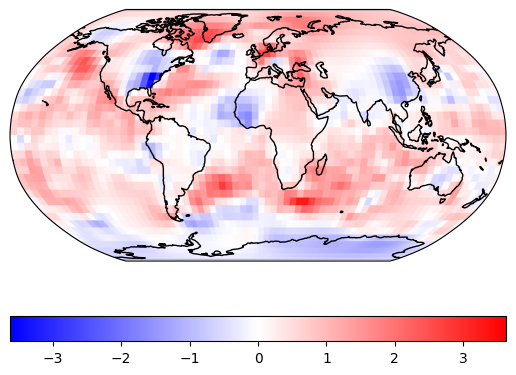

In [20]:
F = plt.Figure()
ax = F.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.coastlines()
m = ax.imshow(
    anom_stat,
    transform=ccrs.PlateCarree(),
    cmap="bwr",
    vmin=-lims_stat,
    vmax=lims_stat,
)
F.colorbar(m, orientation="horizontal")
F

## Kriging for Non-Stationary (Ellipse-based) Version

Requires:

- Full spatial covariance
- Observation values
- Observation indices
- Optionally error covariance

In [21]:
OK_non_stat = OrdinaryKriging(
    cov_non_stat, idx=grid_idx, obs=grid_obs, error_cov=error_cov
)
anom_non_stat = OK_non_stat.solve()
uncert_non_stat = OK_non_stat.get_uncertainty()

anom_non_stat = np.flipud(np.reshape(anom_non_stat, grid.shape))
uncert_non_stat = np.flipud(np.reshape(uncert_non_stat, grid.shape))

lims_non_stat = np.max(np.abs(anom_non_stat))

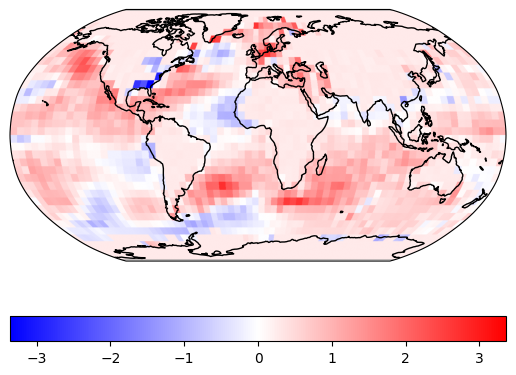

In [22]:
# lims_non_stat = np.max(np.abs(anom_stat))
F2 = plt.Figure()
ax2 = F2.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax2.coastlines()
m2 = ax2.imshow(
    anom_non_stat,
    transform=ccrs.PlateCarree(),
    cmap="bwr",
    vmin=-lims_non_stat,
    vmax=lims_non_stat,
)
F2.colorbar(m2, orientation="horizontal")
F2

## Summary

Main differences are that we haven't defined covariance structure over land in the Ellipse case. One could also compute covariance structure for land using an LSAT training dataset, and combine with the SST covariance over ocean.

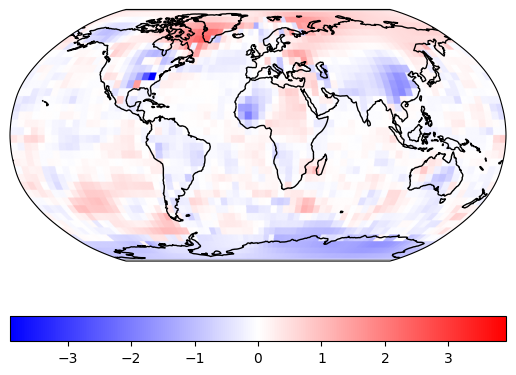

In [23]:
diff = anom_stat - anom_non_stat
lims = np.max(np.abs(diff))
F3 = plt.Figure()
ax3 = F3.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax3.coastlines()
m3 = ax3.imshow(
    diff, transform=ccrs.PlateCarree(), cmap="bwr", vmin=-lims, vmax=lims
)
F3.colorbar(m3, orientation="horizontal")
F3

## Perturbed Field

Here we generate a simulated ocean state from the covariance matrix. We then draw from the error covariance to get a simulated set of observations - this is this then combined with the simulated state. 

In this case, we will use the Ellipse covariance.

Note that the result of a draw will be flattened grid.

With the new `StochasticKriging` class

In [24]:
%%time
StoK = StochasticKriging(
    cov_non_stat, idx=grid_idx, obs=grid_obs, error_cov=error_cov
)
perturbed_anom = StoK.solve()

perturbed_anom = np.flipud(perturbed_anom.reshape((36, 72)))

/Users/josidd/git/noc_gitlab/kriging_fork/glomar_gridding/stochastic.py:441: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  draw = np.random.multivariate_normal(loc, cov, size=ndraws)


CPU times: user 3.84 s, sys: 280 ms, total: 4.12 s
Wall time: 3.47 s


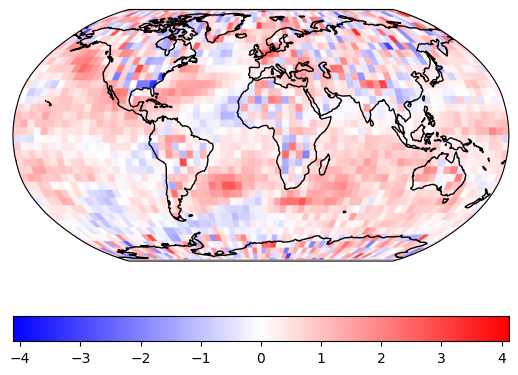

In [25]:
lims_pert = np.max(np.abs(perturbed_anom))

F4 = plt.Figure()
ax4 = F4.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax4.coastlines()
m4 = ax4.imshow(
    perturbed_anom,
    transform=ccrs.PlateCarree(),
    cmap="bwr",
    vmin=-lims_pert,
    vmax=lims_pert,
)
F4.colorbar(m4, orientation="horizontal")
F4

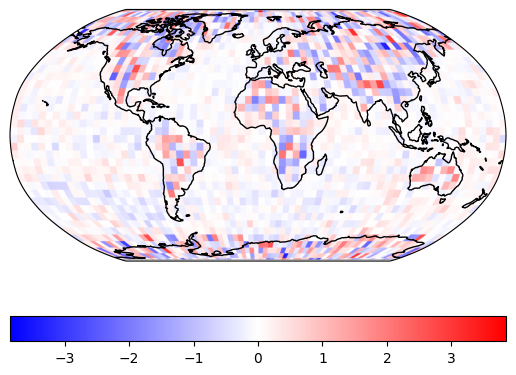

In [26]:
pert_diff = perturbed_anom - anom_non_stat

lims_pert_diff = np.max(np.abs(pert_diff))

F5 = plt.Figure()
ax5 = F5.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax5.coastlines()
m5 = ax5.imshow(
    pert_diff,
    transform=ccrs.PlateCarree(),
    cmap="bwr",
    vmin=-lims_pert_diff,
    vmax=lims_pert_diff,
)
F5.colorbar(m5, orientation="horizontal")
F5